## Functions to grab features from a directory

In [1]:
import os
import numpy as np

def feature_from_file(file_path, feature_type="head", byte_num=512): # will add more feature_type later
    """Retreives features from a file.
  
    Parameters:
    feature_type (str): "head" to get bytes from head of the file.
    byte_num (int): Number of bytes to grab.
    file_path (str): File path of file to get features from.
    
    Returns:
    List of bytes from file_path. 
    """
    if feature_type == "head":
        with open(file_path, 'rb') as f:
            byte = f.read(1)
            index = 1
            features = []
            
            while byte and index <= byte_num:
                features.append(byte)
                index += 1
                byte = f.read(1)
            
            if len(features) < byte_num:
                features.extend([b'' for i in range(byte_num - len(features))])
                
            assert len(features) == byte_num
            return features
    else:
        print("Invalid feature type")

def feature_from_dir(dir_path, feature_type="head", byte_num=512):
    """Takes a directory and grabs features from each file.
    
    Parameters:
    dir_path (str): Path of directory to take features from.
    feature_type (str): Type of features to get.
    byte_num (str): Number of features to take
    
    Return:
    features (list): 2D list of byte_num bytes from each fie in dir_path.
    """
    features = []
    for (dirpath, dirnames, filenames) in os.walk(dir_path):
        for filename in filenames:
            features.append(feature_from_file(os.path.join(dirpath, filename), feature_type, byte_num))
    
    return features

def translate_bytes(dir_features):
    """Translates bytes into integers.
    
    Parameter:
    dir_features (list): 2D list of bytes.
    
    Return:
    translated_features (numpy array): dir_features with bytes translated to integers.
    """
    translated_features = np.zeros((len(dir_features), len(dir_features[0])))
    
    for idx, file_features in enumerate(dir_features):
        x = np.array([int.from_bytes(c, byteorder="big") for c in file_features])
        translated_features[idx] = x
    
    return translated_features

def grab_labels(csv_path):
    """Returns the file paths and file labels from a naivetruth csv.
    
    Parameter:
    csv_path (str): Path of csv file to take labels and paths from.
    
    Returns:
    labels (list): List of label strings from csv_path.
    file_paths (list): List of file_paths from csv_path.
    """
    labels = []
    file_paths = []
    
    with open(csv_path) as label_file:
        csv_reader = csv.reader(label_file, delimiter=',')
        for row in csv_reader:
            file_paths.append(row[0])
            labels.append(row[2])
    
    return labels, file_paths


## Feature preprocessing

In [ ]:
from sklearn.model_selection import train_test_split

test_set_dir = '/Users/ryan/Documents/CS/CDAC/official_xtract/sampler_dataset/pub8'

raw_features = feature_from_dir(test_set_dir, byte_num=512)
untranslated_features = translate_bytes(raw_features)
x = untranslated_features / 255

x_train, x_test, _, _ = train_test_split(x, x)

print(raw_features[0])
print(untranslated_features[0])
print(x[0])

## Keras model

In [ ]:
from keras.optimizers import SGD, Adadelta, Adam
sgd_optimizer = SGD(lr=1, decay=0.001)
adadelta_optimizer = Adadelta(lr=0.1, decay=0)
adam_optimizer = Adam(lr=0.1)

In [ ]:
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense

input_size = len(x_train[0])

input_layer = Input((input_size,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense (64, activation='relu')(encoded)
decoded = Dense(input_size, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
autoencoder.summary()

history = autoencoder.fit(x_train, x_train,
                          epochs=100,
                          batch_size = 256,
                          shuffle=True,
                          validation_data=(x_test, x_test))

encoder = Model(input_layer, encoded)

print(K.eval(autoencoder.optimizer.lr))

In [ ]:
weights = autoencoder.get_weights()
for idx, weight in enumerate(weights):
    print("LAYER {}".format(idx))
    print(weight)

## Results visualization

In [ ]:
%%capture --no-display 
import matplotlib.pyplot as plt

# set up figure
f = plt.figure(figsize=(12,5))
f.add_subplot(1,2, 1)

# plot accuracy as a function of epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

# plot loss as a function of epoch
f.add_subplot(1,2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show(block=True)

## Feature and Label Grabbing

In [2]:
from keras.models import load_model

encoder = load_model("crappy_model.h5")

Using TensorFlow backend.
W1022 13:41:28.548133 4469810624 deprecation_wrapper.py:119] From /Users/ryan/anaconda3/envs/xtract/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1022 13:41:28.559118 4469810624 deprecation_wrapper.py:119] From /Users/ryan/anaconda3/envs/xtract/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1022 13:41:28.606417 4469810624 deprecation_wrapper.py:119] From /Users/ryan/anaconda3/envs/xtract/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1022 13:41:28.607010 4469810624 deprecation_wrapper.py:119] From /Users/ryan/anaconda3/envs/xtract/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is dep

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import csv

le = LabelEncoder()
he = OneHotEncoder()
naivetruth_path = "/Users/ryan/Documents/CS/CDAC/official_xtract/xtract-sampler/automated_training_results/nist_subset.csv"

y, file_paths = grab_labels(naivetruth_path)
y.pop(0) #Gets rid of headers
file_paths.pop(0)

x = []

for file_path in file_paths:
    x.append(feature_from_file(file_path))

x = encoder.predict(translate_bytes(x))
y = he.fit_transform(le.fit_transform(y).reshape(-1, 1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(x, y)

/Users/ryan/anaconda3/envs/xtract/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


## File Classification

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Input

classifier_dim = len(x[0])

classifier_model = Sequential()
classifier_model.add(Dense(16, activation='relu', input_shape=(classifier_dim,)))
classifier_model.add(Dense(12, activation='relu'))
classifier_model.add(Dense(8, activation='relu'))
classifier_model.add(Dense(6, activation='softmax'))

classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier_model.summary()

history = classifier_model.fit(x_train, y_train,
                               epochs=100,
                               batch_size = 16,
                               shuffle=True,
                               validation_data=(x_test, y_test)) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                8208      
_________________________________________________________________
dense_2 (Dense)              (None, 12)                204       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 54        
Total params: 8,570
Trainable params: 8,570
Non-trainable params: 0
_________________________________________________________________
Train on 20241 samples, validate on 6747 samples
Epoch 1/100
20241/20241 [==============================] - 1s 60us/step - loss: 0.4097 - acc: 0.8560 - val_loss: 0.2503 - val_acc: 0.9171
Epoch 2/100
20241/20241 [==============================] - 1s 46us/step - loss: 0.210

20241/20241 [==============================] - 1s 43us/step - loss: 0.0866 - acc: 0.9708 - val_loss: 0.1126 - val_acc: 0.9619
Epoch 54/100
20241/20241 [==============================] - 1s 42us/step - loss: 0.0877 - acc: 0.9706 - val_loss: 0.1035 - val_acc: 0.9658
Epoch 55/100
20241/20241 [==============================] - 1s 42us/step - loss: 0.0885 - acc: 0.9702 - val_loss: 0.1095 - val_acc: 0.9625
Epoch 56/100
20241/20241 [==============================] - 1s 42us/step - loss: 0.0860 - acc: 0.9709 - val_loss: 0.1121 - val_acc: 0.9658
Epoch 57/100
20241/20241 [==============================] - 1s 42us/step - loss: 0.0864 - acc: 0.9709 - val_loss: 0.1192 - val_acc: 0.9627
Epoch 58/100
20241/20241 [==============================] - 1s 43us/step - loss: 0.0870 - acc: 0.9700 - val_loss: 0.1601 - val_acc: 0.9512
Epoch 59/100
20241/20241 [==============================] - 1s 43us/step - loss: 0.0872 - acc: 0.9703 - val_loss: 0.1052 - val_acc: 0.9652
Epoch 60/100
20241/20241 [==============

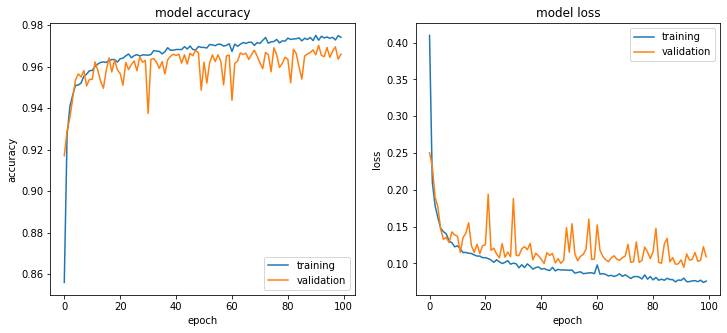

In [6]:
%%capture --no-display 

import matplotlib.pyplot as plt

# set up figure
f = plt.figure(figsize=(12,5))
f.add_subplot(1,2, 1)

# plot accuracy as a function of epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

# plot loss as a function of epoch
f.add_subplot(1,2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show(block=True)

## Validation

In [7]:
import csv

validation_path = "/Users/ryan/Documents/CS/CDAC/official_xtract/xtract-sampler/automated_training_results/cdiac_naivetruth.csv"

validation_labels, validation_paths = grab_labels(validation_path)
validation_labels.pop(0) #Gets rid of headers
validation_paths.pop(0)

validation_features = []

for validation_path in validation_paths:
    validation_features.append(feature_from_file(validation_path))

validation_encoded = encoder.predict(translate_bytes(validation_features))
validation_labels = he.fit_transform(le.fit_transform(validation_labels).reshape(-1, 1)).toarray()

validation_predictions = classifier_model.predict(validation_encoded, verbose=True)

14343/14343 [==============================] - 0s 8us/step


/Users/ryan/anaconda3/envs/xtract/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


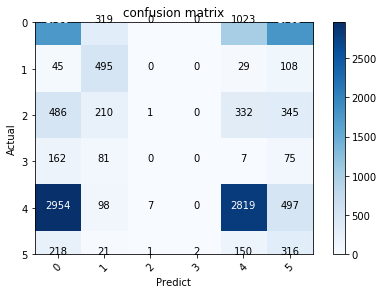

In [8]:
from pycm import ConfusionMatrix
import itertools

# Function: Convert from categorical back to numerical value
def convert_to_index(array_categorical):
    array_index = [np.argmax(array_temp) for array_temp in array_categorical]
    return array_index

def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function modified to plots the ConfusionMatrix object.
    Normalization can be applied by setting `normalize=True`.
    
    Code Reference : 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This script is derived from PyCM repository: https://github.com/sepandhaghighi/pycm
    
    """

    plt_cm = []
    for i in cm.classes :
        row=[]
        for j in cm.classes:
            row.append(cm.table[i][j])
        plt_cm.append(row)
    plt_cm = np.array(plt_cm)
    if normalize:
        plt_cm = plt_cm.astype('float') / plt_cm.sum(axis=1)[:, np.newaxis]     
    plt.imshow(plt_cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(cm.classes))
    plt.xticks(tick_marks, cm.classes, rotation=45)
    plt.yticks(tick_marks, cm.classes)

    fmt = '.2f' if normalize else 'd'
    thresh = plt_cm.max() / 2.
    for i, j in itertools.product(range(plt_cm.shape[0]), range(plt_cm.shape[1])):
        plt.text(j, i, format(plt_cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if plt_cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predict')
# apply conversion function to data
y_test_ind = convert_to_index(validation_labels)
y_pred_test_ind = convert_to_index(validation_predictions)

# compute confusion matrix
cm_test = ConfusionMatrix(y_test_ind, y_pred_test_ind)
np.set_printoptions(precision=2)

# plot confusion matrix result
plt.figure()
plot_confusion_matrix(cm_test,title='confusion matrix')

In [9]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

validation_accuracy = accuracy_score(y_test_ind, y_pred_test_ind)
validation_recall = recall_score(y_test_ind, y_pred_test_ind, average='micro')

print(validation_accuracy)
print(validation_recall)

0.37579306979014154
0.37579306979014154
